# Ecommerce Shipping Analysis pipeline

### **Overview**
This notebook combines **Exploratory Data Analysis (EDA)**, **Preprocessing**, **Model Training**, and **Evaluation** into a single, streamlined pipeline.  
It allows us to:
- Explore and understand the dataset

- Clean and preprocess the data
- Train multiple machine learning models
- Evaluate and select the best performing model
- Save the trained model for backend deployment

**Dataset:** [Customer Analytics – E‑Commerce Shipping Data on Kaggle](https://www.kaggle.com/datasets/prachi13/customer-analytics/data)

In [54]:
import os
import joblib
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    f1_score, accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, auc
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


### Load Raw Data
We load the dataset from the `data/raw` directory.


In [55]:
raw_path = "../data/raw/train.csv"
df = pd.read_csv(raw_path)
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


### Exploratory Data Analysis
In this section, we:

- Inspect data structure

- Check missing values
- Visualize target distribution
- Visualize numerical feature distributions
- Generate a correlation heatmap

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB
None
ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0


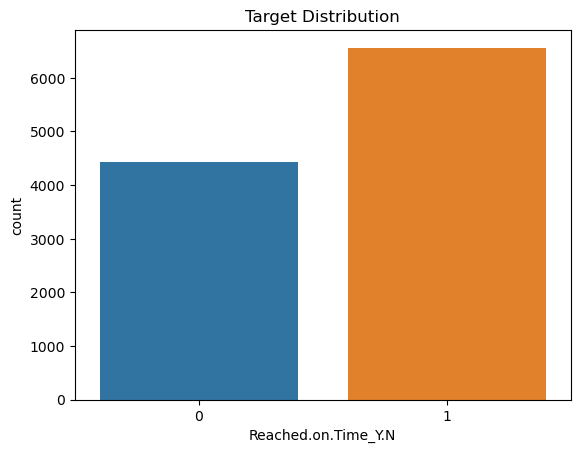

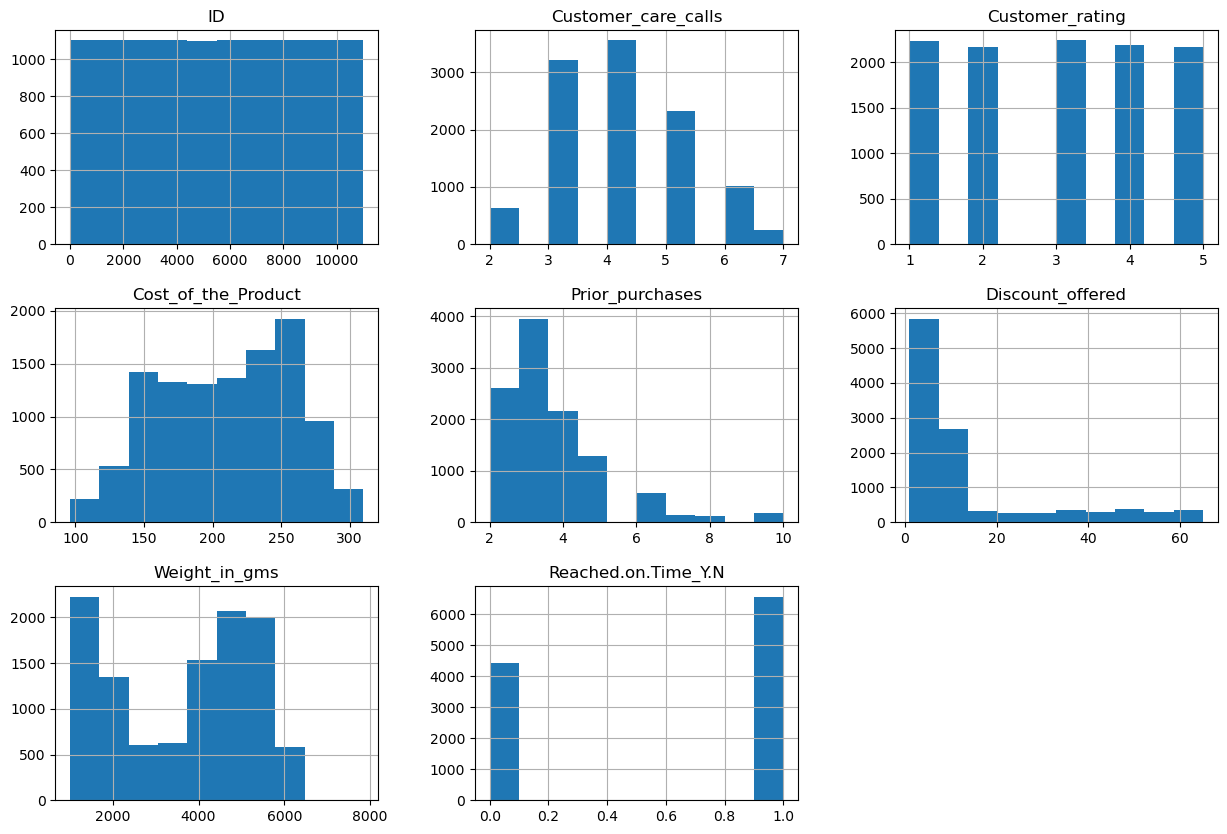

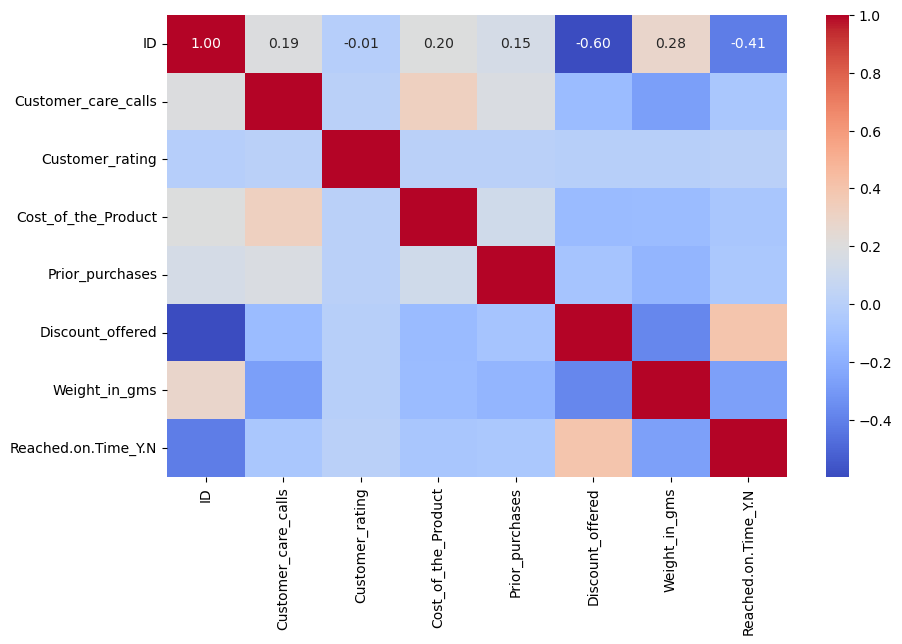

In [56]:
print(df.info())
print(df.isnull().sum())

# Target distribution
sns.countplot(x='Reached.on.Time_Y.N', data=df)
plt.title("Target Distribution")
plt.show()

# Numeric distribution
df.hist(figsize=(15,10))
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

### Feature Preprocessing

We separate features (`X`) from the target (`y`), identify categorical and numerical columns, and create a `ColumnTransformer` for scaling and encoding.

In [57]:
X = df.drop(columns=['Reached.on.Time_Y.N', 'ID'])
y = df['Reached.on.Time_Y.N']

# Identify categorical & numerical columns
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical:", categorical_features)
print("Numerical:", numerical_features)

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

Categorical: ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
Numerical: ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']


### Model Training & Selection

We train multiple models with **5-fold Stratified Cross-Validation** and compare their F1 scores.


In [58]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "SVM (RBF)": SVC(kernel="rbf", probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}

results = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    scores = cross_val_score(pipe, X, y, cv=skf, scoring='f1')
    
    results.append({
        "Model": name,
        "F1 Mean": np.mean(scores),
        "F1 Std": np.std(scores)
    })

results_df = pd.DataFrame(results).sort_values(by="F1 Mean", ascending=False)
display(results_df)


c:\Users\nghoo\AppData\Local\anaconda3\envs\e-commerce_env\lib\site-packages\xgboost\training.py:183: UserWarning: [23:57:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\nghoo\AppData\Local\anaconda3\envs\e-commerce_env\lib\site-packages\xgboost\training.py:183: UserWarning: [23:57:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\nghoo\AppData\Local\anaconda3\envs\e-commerce_env\lib\site-packages\xgboost\training.py:183: UserWarning: [23:57:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\nghoo\AppData\Local\anaconda3\envs\e-commerce_env\lib\site-packages\xgboost\training.py:183: UserWarning: [23:57:10] W

[LightGBM] [Info] Number of positive: 5250, number of negative: 3549
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 584
[LightGBM] [Info] Number of data points in the train set: 8799, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596659 -> initscore=0.391562
[LightGBM] [Info] Start training from score 0.391562
[LightGBM] [Info] Number of positive: 5250, number of negative: 3549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 8799, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596659 -> initscore=0.391562
[LightGBM] [I

,Model,F1 Mean,F1 Std
1,Decision Tree,0.703933,0.006878
4,XGBoost,0.693318,0.008213
8,KNN,0.691673,0.005140
0,Logistic Regression,0.690048,0.010711
2,Random Forest,0.689220,0.006372
6,CatBoost,0.683198,0.013114
5,LightGBM,0.677339,0.010618
3,Gradient Boosting,0.665518,0.010541
7,SVM (RBF),0.660156,0.009860
9,Naive Bayes,0.596100,0.014866


In [59]:
print("🔎 Top models by F1-score:")
display(results_df.head(3))

🔎 Top models by F1-score:


,Model,F1 Mean,F1 Std
1,Decision Tree,0.703933,0.006878
4,XGBoost,0.693318,0.008213
8,KNN,0.691673,0.005140


### Train Best Model on Full Data

We retrain the best-performing model on the full dataset and save it to the `models/` folder for backend usage.

In [60]:
best_model_name = results_df.iloc[0]["Model"]
print(f"Best Model Selected: {best_model_name}")

best_model = models[best_model_name]

final_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_model)
])

final_pipe.fit(X, y)

y_pred_full = final_pipe.predict(X)
print("\n📊 Evaluation on Full Data:")
print("Accuracy:", accuracy_score(y, y_pred_full))
print("F1-score:", f1_score(y, y_pred_full, average="weighted"))
print("\nClassification Report:\n", classification_report(y, y_pred_full))

os.makedirs("../models", exist_ok=True)
model_path = "../models/ecommerce_shipping_best_model.pkl"
joblib.dump(final_pipe, model_path)
print(f"\nModel saved to {model_path}")

Best Model Selected: Decision Tree

📊 Evaluation on Full Data:
Accuracy: 1.0
F1-score: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4436
           1       1.00      1.00      1.00      6563

    accuracy                           1.00     10999
   macro avg       1.00      1.00      1.00     10999
weighted avg       1.00      1.00      1.00     10999


Model saved to ../models/ecommerce_shipping_best_model.pkl


### Model Evaluation (Train/Test Split)

We evaluate the selected model using a separate train-test split and generate:
- Accuracy
- Classification Report

- Confusion Matrix
- ROC Curve


Accuracy: 0.6405

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.52      0.54       887
           1       0.69      0.72      0.71      1313

    accuracy                           0.64      2200
   macro avg       0.62      0.62      0.62      2200
weighted avg       0.64      0.64      0.64      2200



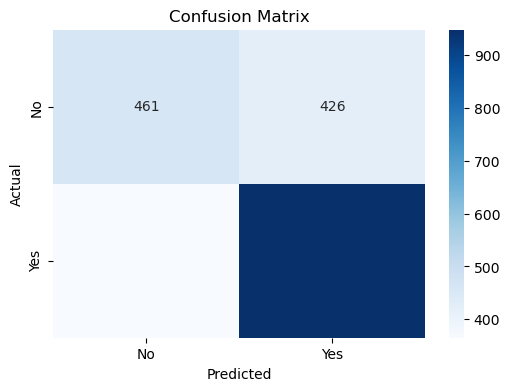

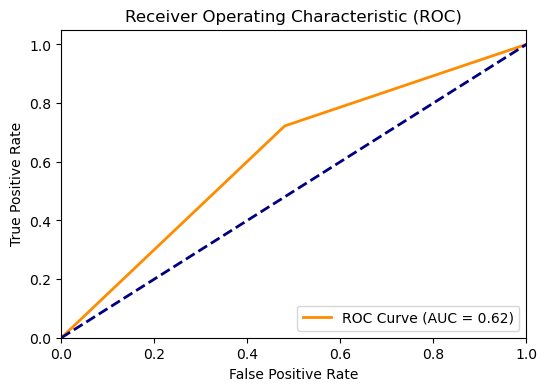

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

final_pipe.fit(X_train, y_train)

y_pred = final_pipe.predict(X_test)
y_proba = final_pipe.predict_proba(X_test)[:, 1]  # dùng cho ROC


acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

### Learning Curve

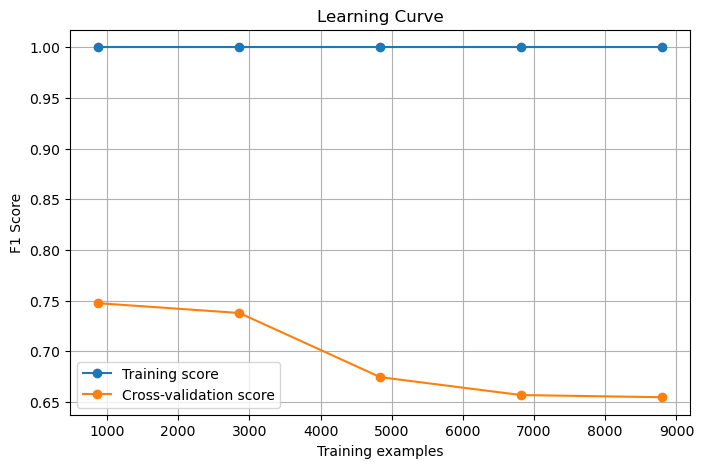

In [62]:
def plot_learning_curve(estimator, X, y, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='f1', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("F1 Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

plot_learning_curve(final_pipe, X, y)

### Feature Importance

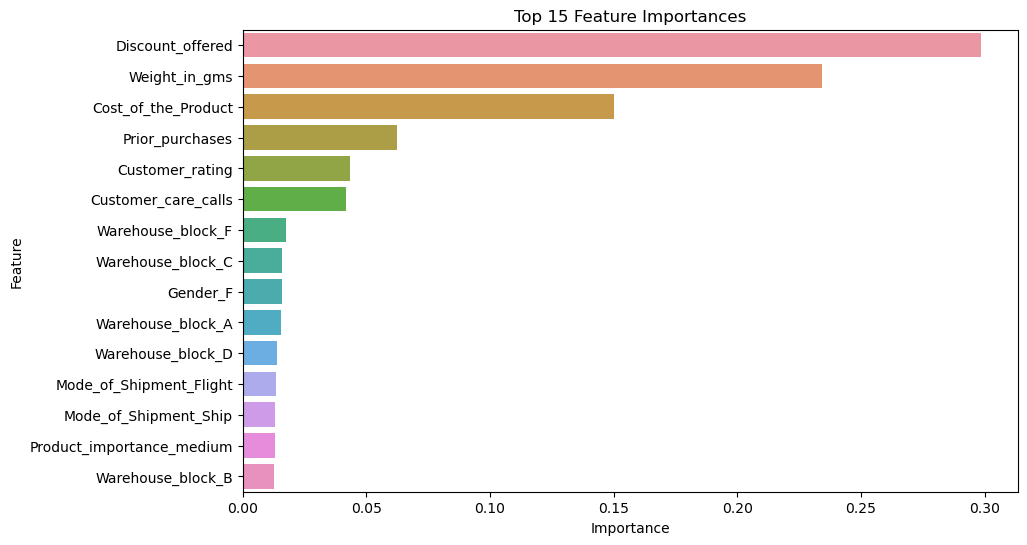

In [63]:
if hasattr(best_model, "feature_importances_"):
    # Lấy tên feature sau khi OneHotEncoder
    ohe_features = final_pipe.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
    all_features = numerical_features + list(ohe_features)

    importances = best_model.feature_importances_
    feat_imp = pd.DataFrame({"Feature": all_features, "Importance": importances})
    feat_imp.sort_values(by="Importance", ascending=False, inplace=True)

    plt.figure(figsize=(10,6))
    sns.barplot(x="Importance", y="Feature", data=feat_imp.head(15))
    plt.title("Top 15 Feature Importances")
    plt.show()

### SHAP values

In [64]:
X_transformed = final_pipe.named_steps['preprocessor'].transform(X)

ohe = final_pipe.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(final_pipe.named_steps['preprocessor'].transformers_[1][2])
feature_names = numerical_features + list(ohe_feature_names)

explainer = shap.Explainer(final_pipe.named_steps['model'], X_transformed)
shap_values = explainer(X_transformed)

shap.summary_plot(shap_values, features=X_transformed, feature_names=feature_names)

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 1.000000, while the model output was 0.000000. If this difference is acceptable you can set check_additivity=False to disable this check.

### Precision-Recall Curve

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
ap = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8,5))
plt.plot(recall, precision, label=f'AP = {ap:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()